In [1]:
import librosa
import librosa.display
import pandas as pd
import IPython.display as ipd
import os
import matplotlib.pyplot as plt #to display the signals of the audio files
%matplotlib inline
from matplotlib.pyplot import specgram
import numpy as np
import tqdm
from tqdm.notebook import tqdm_notebook
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas
from sklearn.preprocessing import LabelEncoder, StandardScaler
import seaborn as sns

from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.models import Sequential
from sklearn.utils import shuffle
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.layers import Activation, Dropout
from tensorflow.keras.layers import BatchNormalization, InputLayer
from tensorflow.keras.layers import Flatten, Dense, LSTM, GRU
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.backend import clear_session
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
audio = r"C:\Users\letym\Desktop\datasets\audio"
metadata = pd.read_csv(r"C:\Users\letym\Desktop\datasets\UrbanSound8K.csv")

In [3]:
metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [4]:
#check whether the dataset is balanced
metadata['class'].value_counts()

air_conditioner     1000
drilling            1000
children_playing    1000
engine_idling       1000
jackhammer          1000
street_music        1000
dog_bark            1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

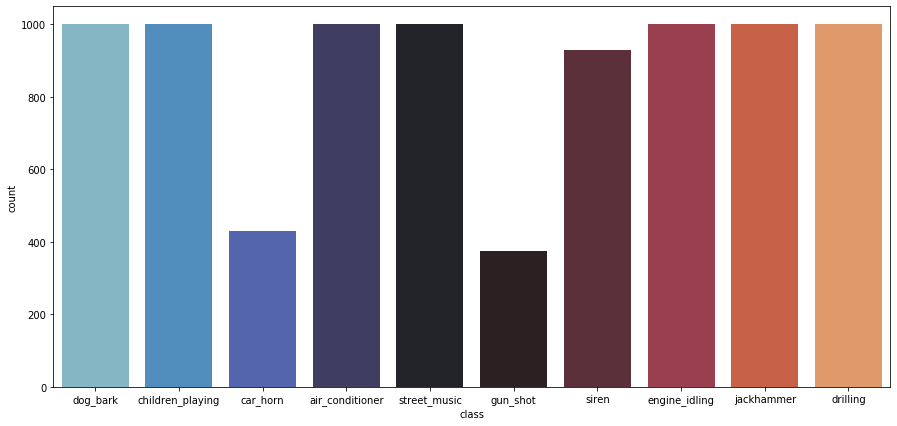

In [5]:
#graphical representation of the balance of the classes
plt.figure(figsize=(15,7))
sns.countplot(metadata['class'], palette = 'icefire')

In [6]:
#DATA PREPROCESSING: FEATURE EXTRACTION #MFCCS
mfcc_features = []
for index, row in metadata.iterrows():
    file_name = os.path.join(os.path.abspath(r"C:\Users\letym\Desktop\datasets\audio"),'fold'+str(row["fold"])+'/', str(row["slice_file_name"]))
    final_class_labels=row["class"]
    fold=row["fold"]
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    normalized_audio = librosa.util.normalize(audio)
    mfccs = librosa.feature.mfcc(y = audio, sr = sample_rate, n_mfcc = 50)
    
    
    mfcc_features.append([mfccs, fold, final_class_labels])

C:\Users\letym\anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1323
  n_fft, y.shape[-1]
C:\Users\letym\anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1103
  n_fft, y.shape[-1]
C:\Users\letym\anaconda3\lib\site-packages\librosa\core\spectrum.py:224: UserWarning: n_fft=2048 is too small for input signal of length=1523
  n_fft, y.shape[-1]


In [7]:
mfcc_features

[[array([[-3.06772552e+02, -1.77592087e+02, -9.91361618e+01,
          -6.59719772e+01, -4.92520256e+01, -5.95824699e+01,
          -1.07877686e+02, -1.67958786e+02, -2.22837250e+02,
          -2.73532562e+02, -3.20838074e+02, -3.58299469e+02,
          -3.91589081e+02, -4.19861816e+02],
         [ 1.27254486e+02,  9.50825653e+01,  7.42132721e+01,
           6.09353790e+01,  5.17881851e+01,  4.67519302e+01,
           4.29447556e+01,  4.60643921e+01,  5.43619537e+01,
           6.44584122e+01,  7.46726761e+01,  8.26809540e+01,
           8.79384995e+01,  9.41782455e+01],
         [-1.13722763e+02, -1.31244415e+02, -1.41885315e+02,
          -1.49715454e+02, -1.55917755e+02, -1.57878036e+02,
          -1.52023682e+02, -1.41128723e+02, -1.36091339e+02,
          -1.31354401e+02, -1.20596260e+02, -1.14046051e+02,
          -1.06593033e+02, -9.31955414e+01],
         [-4.60874748e+01, -5.06342506e+01, -6.17479095e+01,
          -6.66678467e+01, -6.35173569e+01, -6.25285606e+01,
          -

In [8]:
#converting extracted features to a dataframe
extracted_features_df = pd.DataFrame(mfcc_features, columns=['mfccs', 'fold', 'class'])
extracted_features_df.head()

,mfccs,fold,class
0,"[[-306.77255, -177.59209, -99.13616, -65.97198...",5,dog_bark
1,"[[-457.69534, -451.0248, -450.68613, -444.9999...",5,children_playing
2,"[[-468.0367, -467.42264, -481.04654, -486.5948...",5,children_playing
3,"[[-422.42215, -411.9085, -409.46243, -409.0892...",5,children_playing
4,"[[-438.10162, -434.47787, -443.3284, -442.6643...",5,children_playing


In [9]:
extracted_features_df.to_csv('extracted_features_df.csv')

In [10]:
extracted_features_df.to_csv(r'C:\Users\letym\extracted_features_df.csv', index=False)

In [11]:
#definition of train and test folds
train_fold = [1, 2, 3, 4, 6]
test_fold = [5, 7, 8, 9, 10]

In [12]:
train_data = extracted_features_df.loc[extracted_features_df['fold'].isin(train_fold)]
test_data = extracted_features_df.loc[extracted_features_df['fold'].isin(test_fold)]

In [13]:
train_data.shape

(4499, 3)

In [14]:
test_data.shape

(4233, 3)

In [15]:
def add_padding(features, max_len):
    X = [pad_sequences(x, maxlen = max_len, padding="post", truncating= "post") for x in features]
    #X_norm = [StandardScaler().fit_transform(x) for x in X]
    return np.array(X)

In [16]:
train_data['mfccs']

14      [[-522.5725, -386.4712, -296.99313, -252.30666...
15      [[-108.40086, -114.5623, -144.59053, -169.9781...
16      [[-339.26923, -340.62277, -346.57547, -349.043...
17      [[-403.86475, -401.25723, -404.64743, -378.269...
53      [[-691.6492, -526.61676, -444.9639, -420.4165,...
                              ...                        
8718    [[-115.085396, -119.523476, -135.5048, -134.95...
8719    [[-136.10475, -137.66946, -143.18031, -128.955...
8720    [[-80.49424, -78.78577, -86.12432, -90.709206,...
8721    [[-101.9822, -103.19378, -105.43926, -99.08971...
8722    [[-48.350735, -48.05239, -53.214767, -59.56706...
Name: mfccs, Length: 4499, dtype: object

In [17]:
encoder = LabelEncoder()
X_train = add_padding(train_data['mfccs'], 174)
y_train = to_categorical(encoder.fit_transform(train_data['class']))
X_test = add_padding(test_data['mfccs'], 174)
y_test = to_categorical(encoder.fit_transform(test_data['class']))

In [18]:
X_train.shape

(4499, 50, 174)

In [19]:
X_test.shape

(4233, 50, 174)

In [20]:
X_train = X_train.reshape(X_train.shape[0], 50, 174, 1)
X_test = X_test.reshape(X_test.shape[0], 50, 174, 1)

In [21]:
X_train.shape

(4499, 50, 174, 1)

In [22]:
X_test.shape

(4233, 50, 174, 1)

In [23]:
y_train.shape

(4499, 10)

In [24]:
y_test.shape

(4233, 10)

In [25]:
def testfold_pred(model, feature):
    e = LabelEncoder()
    acc = []
    for f in test_fold:
        fold = extracted_features_df.loc[extracted_features_df['fold'] == f]
        if feature == "mfccs":
            y_pred = model.predict(X_test.reshape(X_test.shape[0], 50, 174))
        elif feature == "cnn_mfccs":
            y_pred = model.predict(X_test)
        elif feature == "fnn_mfccs":
            y_pred = model.predict(X_test)
        elif feature == "lenet_mfccs":
            y_pred = model.predict(X_test)
        y_hat = []
        y_true = []
        for i in range(len(y_pred)):
            y_hat.append(np.argmax(y_pred[i]))
            y_true.append(np.argmax(y_test[i]))

        a = accuracy_score(y_true, y_hat)
        acc.append(a)
    std = np.std(acc)
    mean = np.mean(acc)
    return mean, std, acc

In [26]:
rnn_mfccs = Sequential()

rnn_mfccs.add(LSTM(128, input_shape = (50, 174), activation = 'relu', return_sequences = True))
rnn_mfccs.add(Dropout(0.2))
rnn_mfccs.add(Dense(128, activation='relu'))
rnn_mfccs.add(Dense(64, activation='relu'))
rnn_mfccs.add(Dropout(0.2))
rnn_mfccs.add(Dense(48, activation='relu'))
rnn_mfccs.add(Dropout(0.2))
rnn_mfccs.add(Flatten())
rnn_mfccs.add(Dense(10, activation='softmax'))

opt = tf.keras.optimizers.Adam(lr = 1e-3)

rnn_mfccs.compile(loss='categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])

C:\Users\letym\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [27]:
rnn_mfccs.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50, 128)           155136    
                                                                 
 dropout (Dropout)           (None, 50, 128)           0         
                                                                 
 dense (Dense)               (None, 50, 128)           16512     
                                                                 
 dense_1 (Dense)             (None, 50, 64)            8256      
                                                                 
 dropout_1 (Dropout)         (None, 50, 64)            0         
                                                                 
 dense_2 (Dense)             (None, 50, 48)            3120      
                                                                 
 dropout_2 (Dropout)         (None, 50, 48)            0

In [28]:
rnn_mfccs_result = rnn_mfccs.fit(X_train.reshape(X_train.shape[0], 50, 174), y_train, epochs = 50, batch_size = 24, validation_split= 0.2)

Epoch 1/50
150/150 [==============================] - 36s 215ms/step - loss: 33.6674 - accuracy: 0.1314 - val_loss: 16.0572 - val_accuracy: 0.1611
Epoch 2/50
150/150 [==============================] - 28s 188ms/step - loss: 14.6867 - accuracy: 0.1450 - val_loss: 4.8664 - val_accuracy: 0.1144
Epoch 3/50
150/150 [==============================] - 31s 206ms/step - loss: 63.2486 - accuracy: 0.1364 - val_loss: 2.4267 - val_accuracy: 0.1911
Epoch 4/50
150/150 [==============================] - 30s 198ms/step - loss: 3.3810 - accuracy: 0.1550 - val_loss: 2.3257 - val_accuracy: 0.1089
Epoch 5/50
150/150 [==============================] - 30s 201ms/step - loss: 2.4267 - accuracy: 0.1603 - val_loss: 2.2863 - val_accuracy: 0.1744
Epoch 6/50
150/150 [==============================] - 29s 192ms/step - loss: 2.6868 - accuracy: 0.1678 - val_loss: 2.2517 - val_accuracy: 0.1889
Epoch 7/50
150/150 [==============================] - 29s 191ms/step - loss: 2.2707 - accuracy: 0.1781 - val_loss: 2.2755 - va

In [29]:
mean, std, acc = testfold_pred(rnn_mfccs, feature = 'mfccs')

In [30]:
mean, std, acc

(0.24001889912591542,
 0.0,
 [0.24001889912591542,
  0.24001889912591542,
  0.24001889912591542,
  0.24001889912591542,
  0.24001889912591542])

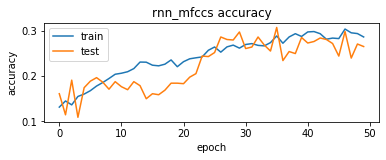

In [31]:
plt.subplot(211)  
plt.plot(rnn_mfccs_result.history['accuracy'])
plt.plot(rnn_mfccs_result.history['val_accuracy'])  
plt.title('rnn_mfccs accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')

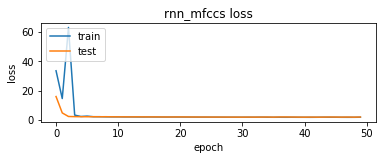

In [32]:
plt.subplot(211)  
plt.plot(rnn_mfccs_result.history['loss'])
plt.plot(rnn_mfccs_result.history['val_loss'])  
plt.title('rnn_mfccs loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')

In [33]:
cnn_mfccs=Sequential()
    
cnn_mfccs.add(Conv2D(16,(3,3),activation='relu',input_shape=(50, 174, 1)))
cnn_mfccs.add(MaxPooling2D(2,2))
cnn_mfccs.add(Dropout(0.2))
cnn_mfccs.add(Conv2D(32,(3,3),activation='relu'))
cnn_mfccs.add(MaxPooling2D(2,2))
cnn_mfccs.add(Dropout(0.2))
cnn_mfccs.add(Conv2D(64,(3,3),activation='relu'))
cnn_mfccs.add(MaxPooling2D(2,2))
cnn_mfccs.add(Dropout(0.2))
cnn_mfccs.add(Conv2D(128,(3,3),activation='relu',padding='same'))
cnn_mfccs.add(MaxPooling2D(2,2))
cnn_mfccs.add(Dropout(0.4))
    
cnn_mfccs.add(Flatten())
cnn_mfccs.add(Dense(256,activation='relu'))
cnn_mfccs.add(Dropout(0.5))
cnn_mfccs.add(Dense(256,activation='relu'))
cnn_mfccs.add(Dropout(0.5))
    
cnn_mfccs.add(Dense(10,activation='softmax'))

opt = tf.keras.optimizers.Adam(lr = 1e-3)

cnn_mfccs.compile(loss='categorical_crossentropy',
             optimizer = opt,
             metrics = ['accuracy'])


C:\Users\letym\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [34]:
cnn_mfccs.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 172, 16)       160       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 86, 16)       0         
 )                                                               
                                                                 
 dropout_3 (Dropout)         (None, 24, 86, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 22, 84, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 11, 42, 32)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 11, 42, 32)       

In [35]:
reduce = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=10, mode='auto')
cnn_mfccs_result = cnn_mfccs.fit(X_train, y_train, epochs = 50, batch_size = 24, callbacks=[reduce], validation_split=0.2)

Epoch 1/50
150/150 [==============================] - 72s 468ms/step - loss: 2.6346 - accuracy: 0.1484 - val_loss: 2.1673 - val_accuracy: 0.1567 - lr: 0.0010
Epoch 2/50
150/150 [==============================] - 70s 467ms/step - loss: 1.9299 - accuracy: 0.2906 - val_loss: 1.8796 - val_accuracy: 0.3589 - lr: 0.0010
Epoch 3/50
150/150 [==============================] - 73s 488ms/step - loss: 1.5790 - accuracy: 0.4471 - val_loss: 1.6996 - val_accuracy: 0.4133 - lr: 0.0010
Epoch 4/50
150/150 [==============================] - 70s 464ms/step - loss: 1.3253 - accuracy: 0.5290 - val_loss: 1.7195 - val_accuracy: 0.3833 - lr: 0.0010
Epoch 5/50
150/150 [==============================] - 69s 461ms/step - loss: 1.1477 - accuracy: 0.6113 - val_loss: 1.4836 - val_accuracy: 0.4822 - lr: 0.0010
Epoch 6/50
150/150 [==============================] - 71s 476ms/step - loss: 0.9981 - accuracy: 0.6652 - val_loss: 1.5747 - val_accuracy: 0.5133 - lr: 0.0010
Epoch 7/50
150/150 [==============================] 

In [36]:
mean, std, acc = testfold_pred(cnn_mfccs, feature = ('cnn_mfccs'))

In [37]:
mean, std, acc

(0.609260571698559,
 0.0,
 [0.609260571698559,
  0.609260571698559,
  0.609260571698559,
  0.609260571698559,
  0.609260571698559])

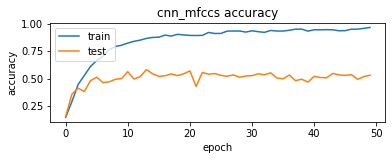

In [38]:
plt.subplot(211)  
plt.plot(cnn_mfccs_result.history['accuracy'])
plt.plot(cnn_mfccs_result.history['val_accuracy'])  
plt.title('cnn_mfccs accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left') 

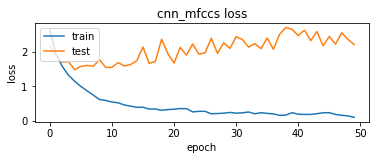

In [39]:
plt.subplot(212)  
plt.plot(cnn_mfccs_result.history['loss'])  
plt.plot(cnn_mfccs_result.history['val_loss'])  
plt.title('cnn_mfccs loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

In [40]:
fnn_mfccs = Sequential()
fnn_mfccs.add(Flatten(input_shape=X_train.shape[1:]))
fnn_mfccs.add(Dense(256, activation="relu"))
fnn_mfccs.add(Dense(128, activation="relu"))
fnn_mfccs.add(Dense(64, activation="relu"))
fnn_mfccs.add(Dense(10, activation = "softmax"))

opt = tf.keras.optimizers.Adam(lr = 1e-3)
fnn_mfccs.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

C:\Users\letym\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [41]:
fnn_mfccs.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 8700)              0         
                                                                 
 dense_7 (Dense)             (None, 256)               2227456   
                                                                 
 dense_8 (Dense)             (None, 128)               32896     
                                                                 
 dense_9 (Dense)             (None, 64)                8256      
                                                                 
 dense_10 (Dense)            (None, 10)                650       
                                                                 
Total params: 2,269,258
Trainable params: 2,269,258
Non-trainable params: 0
_________________________________________________________________


In [42]:
fnn_mfccs_result = fnn_mfccs.fit(X_train, y_train, epochs = 50, batch_size = 24, validation_split = 0.2)

Epoch 1/50
150/150 [==============================] - 13s 78ms/step - loss: 8.5576 - accuracy: 0.4084 - val_loss: 2.7894 - val_accuracy: 0.2744
Epoch 2/50
150/150 [==============================] - 8s 52ms/step - loss: 1.7898 - accuracy: 0.3740 - val_loss: 2.4165 - val_accuracy: 0.2856
Epoch 3/50
150/150 [==============================] - 7s 48ms/step - loss: 1.3323 - accuracy: 0.5671 - val_loss: 2.1949 - val_accuracy: 0.2411
Epoch 4/50
150/150 [==============================] - 7s 46ms/step - loss: 1.2639 - accuracy: 0.5802 - val_loss: 3.1753 - val_accuracy: 0.2378
Epoch 5/50
150/150 [==============================] - 8s 53ms/step - loss: 1.0572 - accuracy: 0.6591 - val_loss: 3.0079 - val_accuracy: 0.3389
Epoch 6/50
150/150 [==============================] - 7s 46ms/step - loss: 0.9295 - accuracy: 0.6885 - val_loss: 4.2570 - val_accuracy: 0.2722
Epoch 7/50
150/150 [==============================] - 8s 51ms/step - loss: 0.7487 - accuracy: 0.7299 - val_loss: 5.4803 - val_accuracy: 0.305

In [43]:
mean, std, acc = testfold_pred(fnn_mfccs, feature = 'fnn_mfccs')

In [44]:
mean, std, acc

(0.4646822584455469,
 0.0,
 [0.4646822584455469,
  0.4646822584455469,
  0.4646822584455469,
  0.4646822584455469,
  0.4646822584455469])

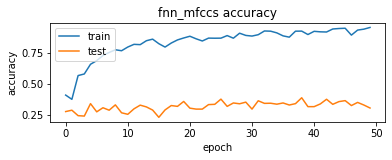

In [45]:
plt.subplot(211)  
plt.plot(fnn_mfccs_result.history['accuracy'])
plt.plot(fnn_mfccs_result.history['val_accuracy'])  
plt.title('fnn_mfccs accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left') 

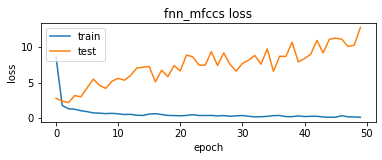

In [46]:
plt.subplot(212)  
plt.plot(fnn_mfccs_result.history['loss'])  
plt.plot(fnn_mfccs_result.history['val_loss'])  
plt.title('fnn_mfccs loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

In [47]:
#LeNet-5

lenet_mfccs = Sequential()
lenet_mfccs.add(Conv2D(32, (3, 3), activation = "tanh", strides=(1, 1), input_shape = (50, 174, 1), padding = "same"))

lenet_mfccs.add(MaxPooling2D(2, 2))
lenet_mfccs.add(Conv2D(32, (3, 3), strides=(1, 1),  activation = "tanh", padding = 'valid'))

lenet_mfccs.add(MaxPooling2D(2, 2))
lenet_mfccs.add(Conv2D(64, (3, 3), strides=(1, 1),  activation = "tanh", padding = 'valid'))
lenet_mfccs.add(MaxPooling2D(2, 2))
lenet_mfccs.add(Flatten())
lenet_mfccs.add(Dense(512, activation = "tanh"))
lenet_mfccs.add(Dropout(0.5))
lenet_mfccs.add(Dense(10, activation = "softmax"))

In [48]:
lenet_mfccs.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 50, 174, 32)       320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 25, 87, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 23, 85, 32)        9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 11, 42, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 9, 40, 64)         18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 4, 20, 64)       

In [49]:
lenet_mfccs.compile(loss = "categorical_crossentropy", optimizer = Adam(1e-3), metrics = ["accuracy"])
lenet_mfccs_result = lenet_mfccs.fit(X_train, y_train, epochs = 50, batch_size = 24,
                               validation_split = 0.2)

Epoch 1/50
150/150 [==============================] - 94s 621ms/step - loss: 1.6680 - accuracy: 0.5293 - val_loss: 2.2170 - val_accuracy: 0.3944
Epoch 2/50
150/150 [==============================] - 95s 632ms/step - loss: 0.6641 - accuracy: 0.7847 - val_loss: 2.4465 - val_accuracy: 0.4278
Epoch 3/50
150/150 [==============================] - 93s 622ms/step - loss: 0.3133 - accuracy: 0.8916 - val_loss: 2.5899 - val_accuracy: 0.4167
Epoch 4/50
150/150 [==============================] - 92s 614ms/step - loss: 0.1398 - accuracy: 0.9583 - val_loss: 2.5982 - val_accuracy: 0.4600
Epoch 5/50
150/150 [==============================] - 92s 612ms/step - loss: 0.0872 - accuracy: 0.9728 - val_loss: 3.3097 - val_accuracy: 0.3744
Epoch 6/50
150/150 [==============================] - 92s 617ms/step - loss: 0.0499 - accuracy: 0.9869 - val_loss: 3.0792 - val_accuracy: 0.4356
Epoch 7/50
150/150 [==============================] - 92s 615ms/step - loss: 0.0252 - accuracy: 0.9944 - val_loss: 3.0332 - val_ac

In [50]:
mean, std, acc = testfold_pred(lenet_mfccs, feature = 'lenet_mfccs')

In [51]:
mean, std, acc

(0.5724072761634774,
 0.0,
 [0.5724072761634774,
  0.5724072761634774,
  0.5724072761634774,
  0.5724072761634774,
  0.5724072761634774])

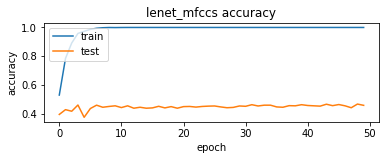

In [52]:
plt.subplot(211)  
plt.plot(lenet_mfccs_result.history['accuracy'])
plt.plot(lenet_mfccs_result.history['val_accuracy'])  
plt.title('lenet_mfccs accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left') 

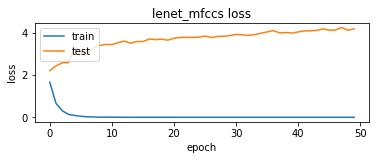

In [53]:
plt.subplot(212)  
plt.plot(lenet_mfccs_result.history['loss'])  
plt.plot(lenet_mfccs_result.history['val_loss'])  
plt.title('lenet_mfccs loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()